In [2741]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Problem

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints.

**39 Features**

1. amount_tsh - Total static head (amount water available to waterpoint)

2. date_recorded - The date the row was entered
3. funder - Who funded the well
4. gps_height - Altitude of the well
5. installer - Organization that installed the well
6. longitude - GPS coordinate
7. latitude - GPS coordinate
8. wpt_name - Name of the waterpoint if there is one
9. num_private -
10. basin - Geographic water basin
11. subvillage - Geographic location
12. region - Geographic location
13. region_code - Geographic location (coded)
14. district_code - Geographic location (coded)
15. lga - Geographic location
16. ward - Geographic location
17. population - Population around the well
18. public_meeting - True/False
19. recorded_by - Group entering this row of data
20. scheme_management - Who operates the waterpoint
21. scheme_name - Who operates the waterpoint
22. permit - If the waterpoint is permitted
23. construction_year - Year the waterpoint was constructed
24. extraction_type - The kind of extraction the waterpoint uses
25. extraction_type_group - The kind of extraction the waterpoint uses
26. extraction_type_class - The kind of extraction the waterpoint uses
27. management - How the waterpoint is managed
28. management_group - How the waterpoint is managed
29. payment - What the water costs
30. payment_type - What the water costs
31. water_quality - The quality of the water
32. quality_group - The quality of the water
33. quantity - The quantity of water
34. quantity_group - The quantity of water
35. source - The source of the water
36. source_type - The source of the water
37. source_class - The source of the water
38. waterpoint_type - The kind of waterpoint
39. waterpoint_type_group - The kind of waterpoint

**Labels**

Status group

1. **functional** - the waterpoint is operational and there are no repairs needed
2. **functional needs repair** - the waterpoint is operational, but needs repairs
3. **non functional** - the waterpoint is not operational


# Imports

In [2742]:
import numpy as np
import pandas as pd
import pathlib as Path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2743]:
train_features_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PumpItUp/train_features.csv')
train_labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PumpItUp/train_labels.csv')
test_features_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PumpItUp/test_features.csv')

In [2744]:
pd.options.display.max_columns=100

In [2745]:
features_df = pd.concat([train_features_df.assign(ind="train"), test_features_df.assign(ind="test")])

# Labels

In [2746]:
train_labels_df.drop(columns=['id'],inplace=True)

In [2747]:
train_labels_df['status_group'] = train_labels_df['status_group'].map({'functional':0, 'non functional':1, 'functional needs repair':2})

In [2748]:
train_labels_df['status_group'] = train_labels_df['status_group'].astype('category')

**Drop unuseful columns**

In [2749]:
features_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,ind
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train


**Fill Na values**

In [2750]:
features_df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [2751]:
col_names= features_df.columns

In [2752]:
def fill_nan_values(df,features):
  for f in features:
    if (df[f].dtypes=="float"):
      print (f)
      df[f].fillna((df[f].mean()), inplace=True)
    else:
      df[f].fillna((df[f].value_counts().index[0]), inplace=True)
fill_nan_values(features_df,col_names)

amount_tsh
longitude
latitude


In [2753]:
joined_df=train_features_df.join(train_labels_df['status_group'])

# Data visualization

In [2754]:
pd.crosstab(joined_df.lga,joined_df.ward)

ward,Aghondi,Akheri,Arash,Arri,Arusha Chini,Babayu,Badi,Badugu,Bahi,Balangidalalu,Baleni,Bangata,Bangwe,Baraa,Bargish,Bariadi,Barikiwa,Barray,Bashay,Bashinet,Bassodesh,Bassotu,Bendera,Berega,Berege,Bereko,Bigwa,Biharamulo Urban,Biirabo,Binagi,Biro,Bitale,Boma,Boma la ng'ombe,Bombambili,Bombo,Bonde la Songwe,Bondeni,Bonga,Bubiki,Buchambi,Budakwa,Budekwa,Budushi,Bugandika,Buganguzi,Bugarama,Bugene,Bugogwe,Bugomora,...,Utengule Usongwe,Utete,Utiri,Utwigu,Uvinza,Uwanja wa Ndege,Uwemba,Uyogo,Uyovu,Uyowa,Uyui,Uyumbu,Vibaoni,Vigaeni,Vigoi,Vigwaza,Vihingo,Vijibweni,Vikindu,Vikumbulu,Vinghawe,Visiga,Vudee,Vuga,Vugiri,Vuje,Vumilia,Vunta,Wala,Wampelembe,Wangama,Wanging'ombe,Wariku,Wasa,Wela,Wino,Wotta,Yaeda Chini,Yakobi,Yombo,Zagayu,Zanka,Ziba,Zinga/Ikerege,Zirai,Ziwani,Zoissa,Zombo,Zongomera,Zuzu
lga,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arusha Rural,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arusha Urban,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Babati,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bagamoyo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,106,0,0,0,141,0,0,0,0,0,0
Bahi,0,0,0,0,0,10,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tunduru,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ukerewe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ulanga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
corr=joined_df.corr()

sns.set(font_scale = 1.2)
plt.figure(figsize=(15, 12))

sns.heatmap(corr)
plt.title('Status group correlations')
plt.show()

In [2755]:
no_cols=['waterpoint_type',
         'recorded_by',
         'wpt_name',
         'subvillage',
         'date_recorded',
         'scheme_name',
         'quantity_group',
         'installer',
         'source_type',
         'payment_type',
         'region',
         'extraction_type_group',
         'waterpoint_type_group',
         'quality_group',
         'management_group']

In [2756]:
features_df.drop(columns=no_cols,inplace=True)

In [2757]:
joined_df.drop(columns=no_cols,inplace=True)

**Creating new features**

In [2758]:
population_mean=joined_df['population'].mean()
print (population_mean)
features_df['is_population_high']=np.where(
    (features_df['population']<=180),
    1,0
)

179.90998316498317


In [2759]:
features_df['is_source_spring']=np.where(
    (features_df['source']=='spring'),
    1,0
)

features_df['is_source_shallow_well']=np.where(
    (features_df['source']=='shallow_well'),
    1,0
)

In [2760]:
features_df['is_insufficient_and_soft']=np.where(
    (features_df['quantity']=='insufficient')& (features_df['water_quality']!='soft'),
    1,0
)

features_df['is_enough_and_soft']=np.where(
    (features_df['quantity']=='enough')& (features_df['water_quality']!='soft'),
    1,0
)

In [2761]:
features_df['water_quality_is_salty']=np.where(
    (features_df['water_quality']=='salty')
    ,1,0
)

features_df['water_quality_is_unknown']=np.where(
    (features_df['water_quality']=='unknown')
    ,1,0
)

features_df['water_quality_is_soft']=np.where(
    (features_df['water_quality']=='soft')
    ,1,0
)

*amount_tsh*

In [2762]:
features_df['amount_tsh'].value_counts()

0.0       52049
500.0      3874
50.0       3103
1000.0     1858
20.0       1812
          ...  
5400.0        1
59.0          1
12.0          1
220.0         1
2550.0        1
Name: amount_tsh, Length: 102, dtype: int64

In [2763]:
features_df.loc[(features_df['amount_tsh']==0.0),'amount_tsh_range']=0
features_df.loc[(features_df['amount_tsh']>0.0) & (features_df['amount_tsh']<1001.0),'amount_tsh_range']=1
features_df.loc[(features_df['amount_tsh']>=1001.0),'amount_tsh_range']=2

*gps_height*

In [2764]:
features_df['gps_height_less']=np.where(
    (features_df['gps_height']<0)
    ,1,0
)
features_df['gps_height_is_zero']=np.where(
    (features_df['gps_height']==0)
    ,1,0
)
features_df['gps_height_more']=np.where(
    (features_df['gps_height']>0)
    ,1,0
)

*num_private*

In [2765]:
features_df['is_num_private_zero']=np.where(
    (features_df['num_private']==0)|(features_df['num_private']==1)|(features_df['num_private']==2)
    ,1,0)

In [2766]:
features_df.drop(columns=['num_private'],inplace=True)
joined_df.drop(columns=['num_private'],inplace=True)

*basin*

In [2767]:
features_df['basin'].replace(to_replace = ('Wami / Ruvu') , value ='Lake Tanganyika' , inplace=True)
joined_df.drop(columns=['basin'],inplace=True)
joined_df=joined_df.join(features_df['basin'])

*population*

In [2768]:
features_df['population'].value_counts()

0       26834
1        8782
200      2370
150      2328
250      2087
        ...  
1193        1
593         1
1065        1
785         1
895         1
Name: population, Length: 1128, dtype: int64

*construction_year*

In [2769]:
features_df['decade'] = features_df['construction_year'] #creating new columns

features_df['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s' , inplace=True)
features_df['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s' , inplace=True)
features_df['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s' , inplace=True)
features_df['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s' , inplace=True)
features_df['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s' , inplace=True)
features_df['decade'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s' , inplace=True)

In [2770]:
features_df.drop(columns=['construction_year'],inplace=True)
joined_df.drop(columns=['construction_year'],inplace=True)

In [2771]:
features_df['is_old_construction']=np.where(
    (features_df['decade']=='60s')|(features_df['decade']=='70s')|(features_df['decade']=='80s')
    ,1,0)
features_df['is_new_construction']=np.where(
    features_df['decade']=='00s'
        ,1,0)

In [2772]:
features_df['is_quantity_dry']=np.where(
    (features_df['quantity']=='dry')
    ,1.0,0.0)

features_df['is_quantity_enough']=np.where(
    (features_df['quantity']=='enough')
    ,1.0,0.0)

features_df['is_water_quality_insufficient']=np.where(
    (features_df['quantity']=='insufficient')
    ,1.0,0.0)

In [2773]:
features_df['is_funder_Government_Of_Tanzania']=np.where(
    (features_df['funder']=='Government Of Tanzania')
    ,1.0,0.0)

features_df['is_funder_Danida']=np.where(
    (features_df['funder']=='Danida')
    ,1.0,0.0)

features_df['is_funder_rwwsp']=np.where(
    (features_df['funder']=='Rwssp')
    ,1.0,0.0)
features_df['is_funder_zero']=np.where(
    (features_df['funder']=='0')
    ,1.0,0.0)

In [2774]:
features_df.drop(columns=['funder'],inplace=True)
joined_df.drop(columns=['funder'],inplace=True)

In [2775]:
features_df['is_extraction_type_class_gravity']=np.where(
    (features_df['extraction_type_class']=='gravity')
    ,1.0,0.0)
features_df['is_extraction_type_class_other']=np.where(
    (features_df['extraction_type_class']=='other')
    ,1.0,0.0)

In [2776]:
features_df['is_never_pay']=np.where(
    (features_df['payment']=='never pay')
    ,1.0,0.0)

In [2777]:
features_df.drop(columns=['id'],inplace=True)
joined_df.drop(columns=['id'],inplace=True)

**Categorical encoding**

In [2778]:
col_names=features_df.columns

In [2779]:
no_cat_cols=['amount_tsh',
            'longitude',
            'latitude',
            'ind']         

In [2780]:
def convert_to_cat(df,features):
  for f in features:
    if (not f in no_cat_cols):
        df[f] = df[f].astype('category')
        df[f] = df[f].cat.codes

    else:
      print (f)
convert_to_cat(features_df,col_names)
convert_to_cat(joined_df,joined_df.columns)

amount_tsh
longitude
latitude
ind
amount_tsh
longitude
latitude


In [2781]:
features_df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,payment,water_quality,quantity,source,source_class,ind,is_population_high,is_source_spring,is_source_shallow_well,is_insufficient_and_soft,is_enough_and_soft,water_quality_is_salty,water_quality_is_unknown,water_quality_is_soft,amount_tsh_range,gps_height_less,gps_height_is_zero,gps_height_more,is_num_private_zero,decade,is_old_construction,is_new_construction,is_quantity_dry,is_quantity_enough,is_water_quality_insufficient,is_funder_Government_Of_Tanzania,is_funder_Danida,is_funder_rwwsp,is_funder_zero,is_extraction_type_class_gravity,is_extraction_type_class_other,is_never_pay
0,6000.0,1450,34.938093,-9.856322,1,10,5,51,1429,109,1,7,0,3,0,7,2,6,1,8,0,train,1,1,0,0,0,0,0,1,2,0,0,1,1,6,0,0,0,1,0,0,0,0,0,1,0,0
1,0.0,1459,34.698766,-2.147466,4,19,2,103,1581,279,1,2,1,3,0,11,0,6,2,5,1,train,0,0,0,0,0,0,0,1,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,1,0,1
2,25.0,746,37.460664,-3.821329,5,20,4,108,1629,250,1,7,1,3,0,7,4,6,1,0,1,train,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0
3,0.0,323,38.486161,-11.155298,7,25,17,87,1576,58,1,7,1,14,5,7,0,6,0,3,0,train,1,0,0,0,0,0,0,1,0,0,0,1,1,5,1,0,1,0,0,0,0,0,0,0,0,1
4,0.0,60,31.130847,-1.825359,4,17,1,26,1692,0,1,7,1,3,0,1,0,6,3,5,1,train,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1


In [2782]:
joined_df.head()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,payment,water_quality,quantity,source,source_class,status_group,basin
0,6000.0,1448,34.938093,-9.856322,10,5,51,1426,109,1,7,0,3,0,7,2,6,1,8,0,0,1
0,6000.0,1448,34.938093,-9.856322,10,5,51,1426,109,1,7,0,3,0,7,2,6,1,8,0,0,0
1,0.0,1457,34.698766,-2.147466,19,2,103,1576,276,-1,2,1,3,0,11,0,6,2,5,1,0,4
1,0.0,1457,34.698766,-2.147466,19,2,103,1576,276,-1,2,1,3,0,11,0,6,2,5,1,0,5
2,25.0,744,37.460664,-3.821329,20,4,108,1624,247,1,7,1,3,0,7,4,6,1,0,1,0,5


In [2783]:
import pandas as pd
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2784]:
train_df=features_df[features_df['ind'] == 'train' ]
test_df=features_df[features_df['ind'] == 'test' ]
train_df.drop('ind',axis='columns',inplace=True)
test_df.drop('ind',axis='columns',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [2785]:
train_df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,payment,water_quality,quantity,source,source_class,is_population_high,is_source_spring,is_source_shallow_well,is_insufficient_and_soft,is_enough_and_soft,water_quality_is_salty,water_quality_is_unknown,water_quality_is_soft,amount_tsh_range,gps_height_less,gps_height_is_zero,gps_height_more,is_num_private_zero,decade,is_old_construction,is_new_construction,is_quantity_dry,is_quantity_enough,is_water_quality_insufficient,is_funder_Government_Of_Tanzania,is_funder_Danida,is_funder_rwwsp,is_funder_zero,is_extraction_type_class_gravity,is_extraction_type_class_other,is_never_pay
0,6000.0,1450,34.938093,-9.856322,1,10,5,51,1429,109,1,7,0,3,0,7,2,6,1,8,0,1,1,0,0,0,0,0,1,2,0,0,1,1,6,0,0,0,1,0,0,0,0,0,1,0,0
1,0.0,1459,34.698766,-2.147466,4,19,2,103,1581,279,1,2,1,3,0,11,0,6,2,5,1,0,0,0,0,0,0,0,1,0,0,0,1,1,2,0,0,0,0,1,0,0,0,0,1,0,1
2,25.0,746,37.460664,-3.821329,5,20,4,108,1629,250,1,7,1,3,0,7,4,6,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0
3,0.0,323,38.486161,-11.155298,7,25,17,87,1576,58,1,7,1,14,5,7,0,6,0,3,0,1,0,0,0,0,0,0,1,0,0,0,1,1,5,1,0,1,0,0,0,0,0,0,0,0,1
4,0.0,60,31.130847,-1.825359,4,17,1,26,1692,0,1,7,1,3,0,1,0,6,3,5,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1


**Oversampling with SMOTE**

In [2786]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

X_sampled, y_sample = smt.fit_sample(train_df, train_labels_df)

print(train_labels_df.value_counts())

y_sampled = pd.Series(y_sample) # converting from array to np.series to see value_counts

print(y_sampled.value_counts())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


status_group
0               32259
1               22824
2                4317
dtype: int64
2    32259
1    32259
0    32259
dtype: int64


In [2787]:
X_sampled = pd.DataFrame(X_sampled,columns=train_df.columns)

In [2788]:
y_sampled=pd.DataFrame(y_sample,columns=train_labels_df.columns)

**Split the dataset**

In [2789]:
RANDOM_SEED=6

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(
    X_sampled,
    y_sampled,
    test_size=0.33,
    shuffle=True,
    random_state=RANDOM_SEED
)

**Normalize the data**

In [2790]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_train)
X_train_np=scaler.transform(X_train)
X_test_np=scaler.transform(X_test)
test_df_np=scaler.transform(test_df)

In [2791]:
X_train= pd.DataFrame(X_train_np,columns = train_df.columns )
X_test= pd.DataFrame(X_test_np,columns = train_df.columns)
test_df= pd.DataFrame(test_df_np,columns=test_df.columns)

# Feature selection

In [2792]:
# from sklearn.ensemble.forest import RandomForestClassifier

# sel = SelectFromModel(RandomForestClassifier(n_estimators = 250))
# sel.fit(X_train, y_train)

In [2793]:
# sel.get_support()

In [2794]:
# selected_feat= X_train.columns[(sel.get_support())]
# len(selected_feat)

In [2795]:
# print(selected_feat)

In [2796]:
# cols=X_train.columns
# cols_remove = []
# for c in cols:
#   if not c in selected_feat:
#     cols_remove.append(c)
# print(cols_remove)

In [2797]:
# X_train.drop(columns=cols_remove,inplace=True)
# X_test.drop(columns=cols_remove,inplace=True)
# test_df.drop(columns=cols_remove,inplace=True)
# joined_df.drop(columns=cols_remove, inplace=True)

# Train the model

**with RandomForest**

In [2799]:
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import accuracy_score, balanced_accuracy_score

# model = RandomForestClassifier()

# model.fit(X_train,y_train)

**with XGBoost**

In [2800]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# setting classifier
model = XGBClassifier(objective = 'multi:softmax', 
                      nrounds = 'min.error.idx',
                      num_class = 3, 
                      booster='gbtree',
                      maximize = False, 
                      eval_metric = 'merror', 
                      eta = .1,
                      max_depth = 16, 
                      colsample_bytree = .4, 
                      n_jobs = -1,
                      learning_rate = 0.1,
                      early_stopping_rounds=10,
                      seed=13)

model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=10, eta=0.1, eval_metric='merror', gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=16, maximize=False,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nrounds='min.error.idx', nthread=None, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=13, silent=None,
              subsample=1, verbosity=1)

**with KNN**

In [2801]:
## knn model

# from sklearn.neighbors import KNeighborsClassifier

# model = KNeighborsClassifier()
# model.fit(X_train, y_train)

# Evaluate the model

In [2802]:
# predictions on train set
y_pred = model.predict(X_train)

# predictions on test set
y_test_pred=model.predict(X_test)

**Confusion matrix for training data**

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feda632e590>)

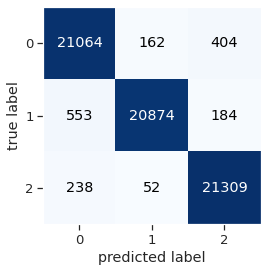

In [2803]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
#confusion matrix
cm = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cm)

**last_best confusion matrix**

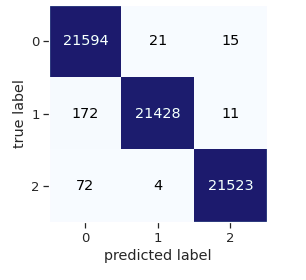

In [2804]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_test_pred)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_test_pred)}")



Accuracy:
TRAIN: 0.9754318322023442
TEST: 0.8614146601120957

Balanced Accuracy:
TRAIN: 0.9754343630754786
TEST: 0.8613801396006276


**Confusion matrix for test data**

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feda6d7fa10>)

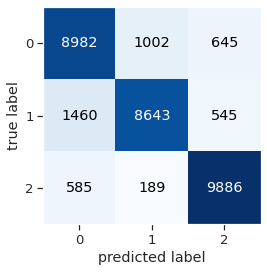

In [2805]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm)

In [2806]:
#predictions on the validation dataset
y_test = model.predict(test_df)

In [2807]:
preds=pd.DataFrame(y_test,columns=['status_group'])

preds.head()

In [2808]:
preds['status_group'] = preds['status_group'].map({0:'functional', 1:'non functional', 2:'functional needs repair'})

In [2809]:
preds.head()

,status_group
0,functional
1,functional needs repair
2,functional
3,non functional
4,functional


# Create the submission file

In [2810]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PumpItUp/SubmissionFormat.csv')
submission['status_group'].count()

14850

In [2811]:
submission.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


In [2812]:
submission['status_group']=preds['status_group']

In [2813]:
submission.head(10000000)

,id,status_group
0,50785,functional
1,51630,functional needs repair
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [2814]:
submission.to_csv('my_submission.csv',index=False)